In [1]:
import datetime, time
import simpy

import shapely.geometry
import pandas as pd

import openclsim.core as core
import openclsim.model as model
import openclsim.plot as plot
import numpy as np

In [2]:
Site = type(
    "Site",
    (
        core.Identifiable,
        core.Log,
        core.Locatable,
        core.HasContainer,
        core.HasResource,
    ),
    {},
)
TransportProcessingResource = type(
    "TransportProcessingResource",
    (
        core.Identifiable,
        core.Log,
        core.ContainerDependentMovable,
        core.Processor,
        core.HasResource,
    ),
    {},
)

In [3]:
def run(NR_BARGES, total_amount):
    simulation_start = 0
    my_env = simpy.Environment(initial_time=simulation_start)
    registry = {}

    location_from_site = shapely.geometry.Point(4.18055556, 52.18664444)
    location_to_site = shapely.geometry.Point(4.25222222, 52.11428333)

    data_from_site = {"env": my_env,
                      "name": "from_site",
                      "geometry": location_from_site,
                      "capacity": total_amount,
                      "level": total_amount,
                      "nr_resources":1
                     }
    from_site = Site(**data_from_site)

    location_to_site = shapely.geometry.Point(4.25222222, 52.11428333)
    data_to_site = {"env": my_env,
                    "name": "to_site",
                    "geometry": location_to_site,
                    "capacity": total_amount,
                    "level": 0,
                    "nr_resources":4
                   }
    to_site = Site(**data_to_site)

    vessels = {}

    for i in range(NR_BARGES):
        vessels[f"vessel{i}"] = TransportProcessingResource(
            env=my_env,
            name=f"barge{i}",
            geometry=location_from_site, 
            capacity=10,
            compute_v=lambda x: 10
        )
    cutter = TransportProcessingResource(
        env=my_env,
        name=f"cutter",
        geometry=location_from_site, 
        capacity=10,
        compute_v=lambda x: 10
    )
    vessels['cutter'] = cutter
    

    activities = {}
    for i in range(NR_BARGES):
        amount = np.random.randint(3,10)
        duration=np.random.randint(10,55)

        requested_resources={}
        activities[f"activity{i}"] = model.WhileActivity(
            env=my_env,
            name=f"while_sequential_activity_subcycle{i}",
            registry=registry,
            sub_processes=[model.SequentialActivity(
                env=my_env,
                name=f"sequential_activity_subcycle{i}",
                registry=registry,
                sub_processes=[
                    model.BasicActivity(
                        env=my_env,
                        name=f"basic activity{i}",
                        registry=registry,
                        duration=duration,
                        additional_logs=[vessels[f"vessel{i}"]],
                    ),
                    model.MoveActivity(
                        env=my_env,
                        name=f"sailing empty{i}",
                        registry=registry,
                        mover=vessels[f"vessel{i}"],
                        destination=from_site,
                        duration=duration,
                    ),
                    model.ShiftAmountActivity(
                        env=my_env,
                        name=f"loading{i}",
                        registry=registry,
                        processor=cutter,
                        origin=from_site,
                        destination=vessels[f"vessel{i}"],
                        amount=amount,
                        duration=5*amount,
                        requested_resources=requested_resources,
                    ),
                    model.MoveActivity(
                        env=my_env,
                        name=f"sailing full{i}",
                        registry=registry,
                        mover=vessels[f"vessel{i}"],
                        destination=to_site,
                        duration=duration,
                    ),
                    model.ShiftAmountActivity(
                        env=my_env,
                        name=f"unloading{i}",
                        registry=registry,
                        processor=vessels[f"vessel{i}"],
                        origin=vessels[f"vessel{i}"],
                        destination=to_site,
                        amount=amount,
                        duration=duration,
                        requested_resources=requested_resources,
                    ),
                ],
            )],
            condition_event=[
                {
                    "type": "container", 
                    "concept": to_site, 
                    "state": "full",
                    "id_":"default_reservations"
                }
            ],
        )

    model.register_processes(list(activities.values()))
    my_env.run()
    
    return {
        "vessels": vessels,
        "activities":activities,
        "from_site":from_site,
        "to_site":to_site,
    }


In [4]:
%%time

res = run(3,1000)
vessels = res['vessels']
activities = res['activities']
cutter = vessels['cutter']
to_site = res['to_site']
from_site = res['from_site']

CPU times: user 651 ms, sys: 2.2 ms, total: 653 ms
Wall time: 651 ms


In [5]:
fig = plot.get_gantt_chart([*vessels.values()])

In [6]:
fig = plot.get_gantt_chart([from_site, to_site,cutter])

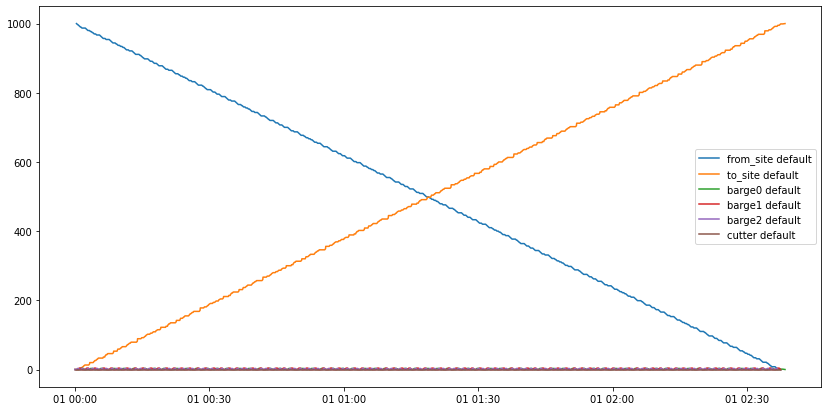

In [7]:
fig = plot.get_step_chart([from_site, to_site, *vessels.values()])

In [8]:
data = []
for i in range(len(vessels.values()) - 1):
    vessel = vessels[f'vessel{i}']
    activity = activities[f'activity{i}']
    sub_act = activity.sub_processes[0].sub_processes[-1]
    log = pd.DataFrame(vessel.log)
    nr_trips = len(log[(log.ActivityID == sub_act.id) & (log.ActivityState == "START")])
    data.append({
        'name':vessel.name, 
        'trips':nr_trips, 
        'theoretical production': (sub_act.amount / (4*sub_act.duration+ 5*sub_act.amount)),
        'production':(nr_trips * sub_act.amount) / ((log.Timestamp.max() - log.Timestamp.min()).total_seconds()),
    })
df = pd.DataFrame(data).sort_values(by=['production'],ascending=False)
df

,name,trips,theoretical production,production
2,barge2,146,0.050847,0.046526
1,barge1,90,0.040000,0.038087
0,barge0,68,0.022222,0.021451
